Machine learning (metodo supervisado)

## ¿Qué determina realmente el precio de un auto?


# Que aprendera de esto
Al final de este caso, estará familiarizado con el uso de XGBoost como modelo de referencia para analizar qué variables influyen más en el precio de los autos usados. Específicamente, aprenderá cómo este algoritmo permite capturar relaciones no lineales y cuantificar la importancia relativa de cada feature, de tal manera que pueda intuir mejor qué factores realmente determinan el valor de un vehículo. Durante el estudio de caso, realizará un EDA detallado para comprender la estructura del conjunto de datos y detectar patrones relevantes.

## Introduccion al proyecto
*Contexto comercial.*

Trabaja para una empresa dedicada a la compra y venta de autos usados, donde miles de vehículos se publican diariamente con precios muy variables según sus características. Para mejorar la transparencia del mercado y optimizar las recomendaciones de precios, la empresa necesita comprender qué factores realmente determinan el valor final de un auto. Aunque los vendedores suelen basarse en intuiciones o comparaciones superficiales, la compañía busca un enfoque basado en datos que permita identificar con precisión qué atributos influyen más en el precio y en qué magnitud.

*Problema comercial.*

¿Cuáles son las variables que más impactan en el precio de un auto usado y cómo se puede cuantificar su importancia relativa?

*Contexto analítico.*

El equipo de datos le ha proporcionado un conjunto de información detallada sobre miles de vehículos, incluyendo características como los caballos, el torque, peso del vehiculo, millaje y otras especificaciones técnicas. A diferencia de otros casos, aquí no buscamos clasificar ni detectar anomalías, sino entender la estructura del mercado y determinar qué atributos explican mejor la variación en los precios. Para ello, utilizaremos XGBoost como modelo principal, aprovechando su capacidad para capturar relaciones complejas y generar métricas de importancia de variables.


## EDA

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.colors as mcolors
import seaborn as sns
import scipy
from scipy import stats
import sklearn
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb
import sys
import subprocess
import time



vemos las primeras filas del df para saber donde estamos parados

In [36]:
df=pd.read_csv('../data/datasetautostop.csv')
display(df.head())

,Brand,Model,Year,Country,Condition,Engine_Size,Horsepower,Torque,Weight,Top_Speed,...,Mileage,Popularity,Safety_Rating,Number_of_Owners,Market_Demand,Insurance_Cost,Production_Units,Log_Price,Log_Mileage,Modification
0,Nissan,720S,2006,Asia,used,3.7,420,705,1785,238,...,96664,Low,2,4,Medium,13410,5000,11.309352,11.479007,V-Spec
1,McLaren,911 Turbo S,2009,Europe,new,5.3,1104,766,992,386,...,159630,High,2,2,Medium,10795,1000,12.639334,11.980620,NaN
2,Chevrolet,M4 Competition,2009,USA,new,5.5,153,1573,2022,397,...,111496,High,1,2,Low,1716,20000,12.948902,11.621753,NaN
3,Bugatti,Chiron,1982,Asia,used,5.4,544,1009,1091,151,...,217228,High,2,4,Medium,11618,20000,11.725542,12.288707,NaN
4,Nissan,Chiron,2022,Europe,new,2.4,980,693,1232,385,...,150318,Low,3,2,Medium,11324,100000,11.229289,11.920515,NaN


Convertimos la columna year en formato fecha con datetime

In [37]:
df['Year'] = pd.to_datetime(df['Year'], format='%Y')

A continuacion nos preparamos para el analisis y como es imposible analisar año por año lo que hacemos es agrupar los años por decadas

Realizamos un informe de calidad de datos para saber todo las condiciones que tiene nuestro df

In [38]:
# Informe de calidad de datos del DataFrame
def informe_calidad_datos(df):
    print('--- INFORME DE CALIDAD DE DATOS ---')
    print('\nDimensiones del DataFrame:')
    print(f'Filas: {df.shape[0]}, Columnas: {df.shape[1]}')
    print('\nTipos de variables:')
    print(df.dtypes)
    print('\nValores nulos por columna:')
    print(df.isnull().sum())
    print('\nPorcentaje de valores nulos por columna:')
    print((df.isnull().mean()*100).round(2))
    print('\nCantidad de filas duplicadas:')
    print(df.duplicated().sum())
    print('\nEstadísticas descriptivas (numéricas):')
    print(df.describe().T)
    print('\nEstadísticas descriptivas (categóricas):')
    print(df.describe(include=['object', 'category']).T)
    print('\nValores únicos por columna:')
    print(df.nunique())
    print('\n--- FIN DEL INFORME ---')

# Ejecutar el informe de calidad de datos
informe_calidad_datos(df)

--- INFORME DE CALIDAD DE DATOS ---

Dimensiones del DataFrame:
Filas: 5000, Columnas: 27

Tipos de variables:
Brand                         object
Model                         object
Year                  datetime64[ns]
Country                       object
Condition                     object
Engine_Size                  float64
Horsepower                     int64
Torque                         int64
Weight                         int64
Top_Speed                      int64
Acceleration_0_100           float64
Fuel_Type                     object
Drivetrain                    object
Transmission                  object
Fuel_Efficiency              float64
CO2_Emissions                  int64
Price                          int64
Mileage                        int64
Popularity                    object
Safety_Rating                  int64
Number_of_Owners               int64
Market_Demand                 object
Insurance_Cost                 int64
Production_Units               int64
L

In [39]:
df = df.drop(columns=['Modification'])

### Como la columna 'modification' tenia un alto porcentaje de valores nulos, y no nos era de suma importancia para nuestro modelo decidi eliminarla

In [40]:
def agrupar_por_decada(df):
   
    # Asegurarse de que 'Year' es tipo datetime
    if not np.issubdtype(df['Year'].dtype, np.datetime64):
        df['Year'] = pd.to_datetime(df['Year'], format='%Y')
    # Extraer el año como entero
    years = df['Year'].dt.year
    # Calcular la década
    df['decada'] = (years // 10) * 10
    df['decada'] = df['decada'].astype(str) + "s"
    return df

# Aplicar la función al DataFrame
df = agrupar_por_decada(df)
display(df[['Year', 'decada']].head())

,Year,decada
0,2006-01-01,2000s
1,2009-01-01,2000s
2,2009-01-01,2000s
3,1982-01-01,1980s
4,2022-01-01,2020s


## Análisis de Calidad de la Variable Log_Price
A continuación, realizamos un análisis exhaustivo de la variable transformada **Log_Price** para verificar su calidad, detectar outliers y valores nulos antes de usarla en el modelo.

Calculando Log_Price a partir de Price...
Columna Log_Price calculada exitosamente usando: np.log1p(Price)
   • Price mínimo: $20,014.00
   • Price máximo: $499,991.00
   • Log_Price mínimo: 9.9042
   • Log_Price máximo: 13.1223
1. INFORMACIÓN BÁSICA:
   Tipo de dato: float64
   Total de registros: 5,000

🔍 2. VALORES NULOS Y FALTANTES:
   Valores nulos: 0 (0.00%)
3. VALORES INFINITOS Y NEGATIVOS:
   Valores infinitos: 0
   Valores negativos: 0
   Valores igual a cero: 0
4. ESTADÍSTICAS DESCRIPTIVAS:
   Media: 12.2670
   Mediana: 12.4883
   Desviación estándar: 0.7411
   Mínimo: 9.9042
   Máximo: 13.1223
   Rango: 3.2181
Cuartil 25%: 11.8756
   Cuartil 50% (Mediana): 12.4883
   Cuartil 75%: 12.8504
   Rango Intercuartílico (IQR): 0.9748
5. DETECCIÓN DE OUTLIERS (Método IQR):
   Límite inferior: 10.4134
   Límite superior: 14.3125
   Outliers inferiores: 150
   Outliers superiores: 0
   Total de outliers: 150 (3.00%)
   ⚠️  Se detectaron 150 outliers
 6. DISTRIBUCIÓN DE LA VARIABLE:
   

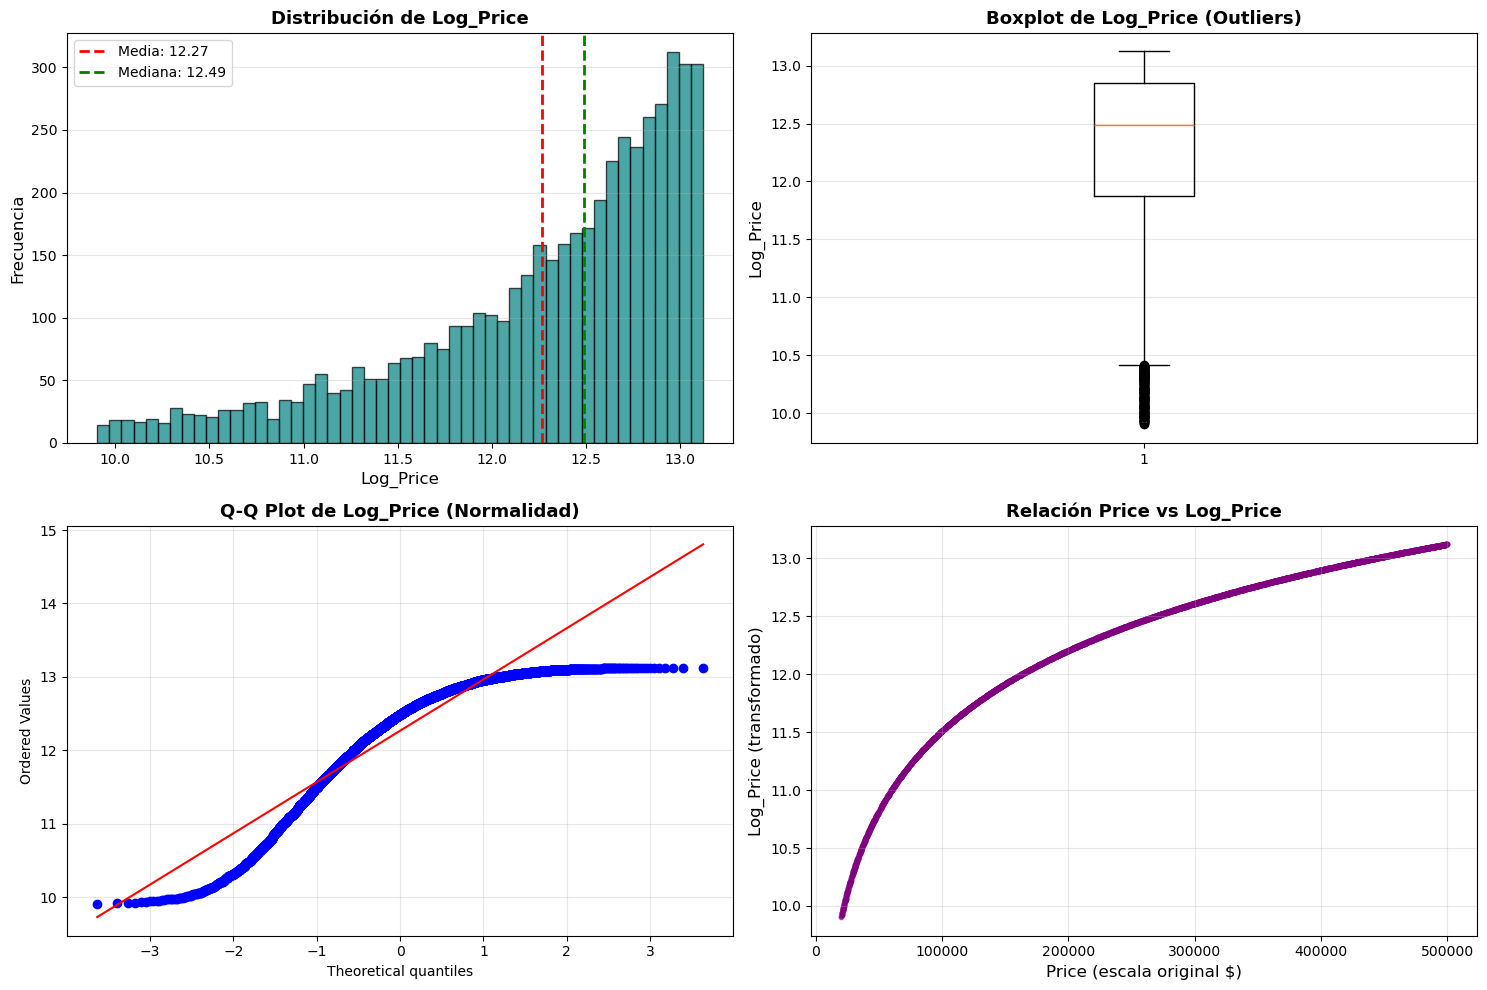


                    RESUMEN Y RECOMENDACIONES


 COMPARACIÓN CON PRICE ORIGINAL:
   Asimetría Price:     -0.0397
   Asimetría Log_Price: -1.1133


In [41]:
# Calcular Log_Price a partir de Price (siempre recalcula)
print('Calculando Log_Price a partir de Price...')
df['Log_Price'] = np.log1p(df['Price'])
print('Columna Log_Price calculada exitosamente usando: np.log1p(Price)')
print(f'   • Price mínimo: ${df["Price"].min():,.2f}')
print(f'   • Price máximo: ${df["Price"].max():,.2f}')
print(f'   • Log_Price mínimo: {df["Log_Price"].min():.4f}')
print(f'   • Log_Price máximo: {df["Log_Price"].max():.4f}')

# 1. INFORMACIÓN BÁSICA
print('1. INFORMACIÓN BÁSICA:')
print(f'   Tipo de dato: {df["Log_Price"].dtype}')
print(f'   Total de registros: {len(df["Log_Price"]):,}')

# 2. VALORES NULOS
print('\n🔍 2. VALORES NULOS Y FALTANTES:')
nulos_log_price = df['Log_Price'].isnull().sum()
porcentaje_nulos_log = (nulos_log_price / len(df)) * 100
print(f'   Valores nulos: {nulos_log_price} ({porcentaje_nulos_log:.2f}%)')

# 3. VALORES INFINITOS Y NEGATIVOS
print('3. VALORES INFINITOS Y NEGATIVOS:')
valores_infinitos = np.isinf(df['Log_Price']).sum()
valores_negativos_log = (df['Log_Price'] < 0).sum()
valores_cero_log = (df['Log_Price'] == 0).sum()

print(f'   Valores infinitos: {valores_infinitos}')
print(f'   Valores negativos: {valores_negativos_log}')
print(f'   Valores igual a cero: {valores_cero_log}')

# 4. ESTADÍSTICAS DESCRIPTIVAS
print('4. ESTADÍSTICAS DESCRIPTIVAS:')
print(f'   Media: {df["Log_Price"].mean():.4f}')
print(f'   Mediana: {df["Log_Price"].median():.4f}')
print(f'   Desviación estándar: {df["Log_Price"].std():.4f}')
print(f'   Mínimo: {df["Log_Price"].min():.4f}')
print(f'   Máximo: {df["Log_Price"].max():.4f}')
print(f'   Rango: {df["Log_Price"].max() - df["Log_Price"].min():.4f}')

# Cuartiles
q25_log = df['Log_Price'].quantile(0.25)
q50_log = df['Log_Price'].quantile(0.50)
q75_log = df['Log_Price'].quantile(0.75)
iqr_log = q75_log - q25_log

print(f'Cuartil 25%: {q25_log:.4f}')
print(f'   Cuartil 50% (Mediana): {q50_log:.4f}')
print(f'   Cuartil 75%: {q75_log:.4f}')
print(f'   Rango Intercuartílico (IQR): {iqr_log:.4f}')

# 5. OUTLIERS (Método IQR)
print('5. DETECCIÓN DE OUTLIERS (Método IQR):')
limite_inferior_log = q25_log - 1.5 * iqr_log
limite_superior_log = q75_log + 1.5 * iqr_log

outliers_inferiores_log = (df['Log_Price'] < limite_inferior_log).sum()
outliers_superiores_log = (df['Log_Price'] > limite_superior_log).sum()
total_outliers_log = outliers_inferiores_log + outliers_superiores_log
porcentaje_outliers_log = (total_outliers_log / len(df)) * 100

print(f'   Límite inferior: {limite_inferior_log:.4f}')
print(f'   Límite superior: {limite_superior_log:.4f}')
print(f'   Outliers inferiores: {outliers_inferiores_log}')
print(f'   Outliers superiores: {outliers_superiores_log}')
print(f'   Total de outliers: {total_outliers_log} ({porcentaje_outliers_log:.2f}%)')

if total_outliers_log > 0:
    print(f'   ⚠️  Se detectaron {total_outliers_log} outliers')
    # Mostrar algunos ejemplos de outliers
    if outliers_superiores_log > 0:
        outliers_superiores_valores = df[df['Log_Price'] > limite_superior_log]['Log_Price'].head(5)
        print(f'\n   📋 Ejemplos de outliers superiores:')
        for idx, val in outliers_superiores_valores.items():
            precio_original = np.expm1(val)
            print(f'      Log_Price: {val:.4f} (Price original: ${precio_original:,.2f})')
else:
    print('   No se detectaron outliers')

# 6. DISTRIBUCIÓN
print(' 6. DISTRIBUCIÓN DE LA VARIABLE:')
print(f'   Asimetría (Skewness): {df["Log_Price"].skew():.4f}')
print(f'   Curtosis (Kurtosis): {df["Log_Price"].kurtosis():.4f}')

# 7. CORRELACIÓN CON PRICE ORIGINAL
print('7. CORRELACIÓN CON PRICE ORIGINAL:')
if 'Price' in df.columns:
    correlacion = df[['Price', 'Log_Price']].corr().iloc[0, 1]
    print(f'   Correlación Price vs Log_Price: {correlacion:.6f}')


# 8. VISUALIZACIÓN
print('\n 8. GENERANDO VISUALIZACIONES...')

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histograma de Log_Price
axes[0, 0].hist(df['Log_Price'].dropna(), bins=50, color='teal', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df['Log_Price'].mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {df["Log_Price"].mean():.2f}')
axes[0, 0].axvline(df['Log_Price'].median(), color='green', linestyle='--', linewidth=2, label=f'Mediana: {df["Log_Price"].median():.2f}')
axes[0, 0].set_xlabel('Log_Price', fontsize=12)
axes[0, 0].set_ylabel('Frecuencia', fontsize=12)
axes[0, 0].set_title('Distribución de Log_Price', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3, axis='y')

# Boxplot de Log_Price
axes[0, 1].boxplot(df['Log_Price'].dropna(), vert=True)
axes[0, 1].set_ylabel('Log_Price', fontsize=12)
axes[0, 1].set_title('Boxplot de Log_Price (Outliers)', fontsize=13, fontweight='bold')
axes[0, 1].grid(alpha=0.3, axis='y')

# Q-Q Plot para verificar normalidad

stats.probplot(df['Log_Price'].dropna(), dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot de Log_Price (Normalidad)', fontsize=13, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Comparación Price vs Log_Price (escala original)
if 'Price' in df.columns:
    axes[1, 1].scatter(df['Price'], df['Log_Price'], alpha=0.5, s=10, color='purple')
    axes[1, 1].set_xlabel('Price (escala original $)', fontsize=12)
    axes[1, 1].set_ylabel('Log_Price (transformado)', fontsize=12)
    axes[1, 1].set_title('Relación Price vs Log_Price', fontsize=13, fontweight='bold')
    axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 9. RESUMEN Y RECOMENDACIONES
print('\n' + '='*70)
print('                    RESUMEN Y RECOMENDACIONES')
print('='*70 + '\n')

# Evaluación general
problemas_log = []
if nulos_log_price > 0:
    problemas_log.append(f'• Valores nulos: {nulos_log_price} registros')
if valores_infinitos > 0:
    problemas_log.append(f'• Valores infinitos: {valores_infinitos} registros')
if valores_negativos_log > 0:
    problemas_log.append(f'• Valores negativos: {valores_negativos_log} registros')
if porcentaje_outliers_log > 5:
    problemas_log.append(f'• Alto porcentaje de outliers: {porcentaje_outliers_log:.2f}%')
if abs(df['Log_Price'].skew()) > 1:
    problemas_log.append('• Distribución muy asimétrica (revisar transformación)')


# Comparación con Price original
print('\n COMPARACIÓN CON PRICE ORIGINAL:')
if 'Price' in df.columns:
    skew_price = df['Price'].skew()
    skew_log = df['Log_Price'].skew()
    print(f'   Asimetría Price:     {skew_price:.4f}')
    print(f'   Asimetría Log_Price: {skew_log:.4f}')
    mejora = abs(skew_price) - abs(skew_log)

## GRAFICO I
Este grafico esta diseñado con la finalidad de saber en que epoca se fabricaron mas autos.

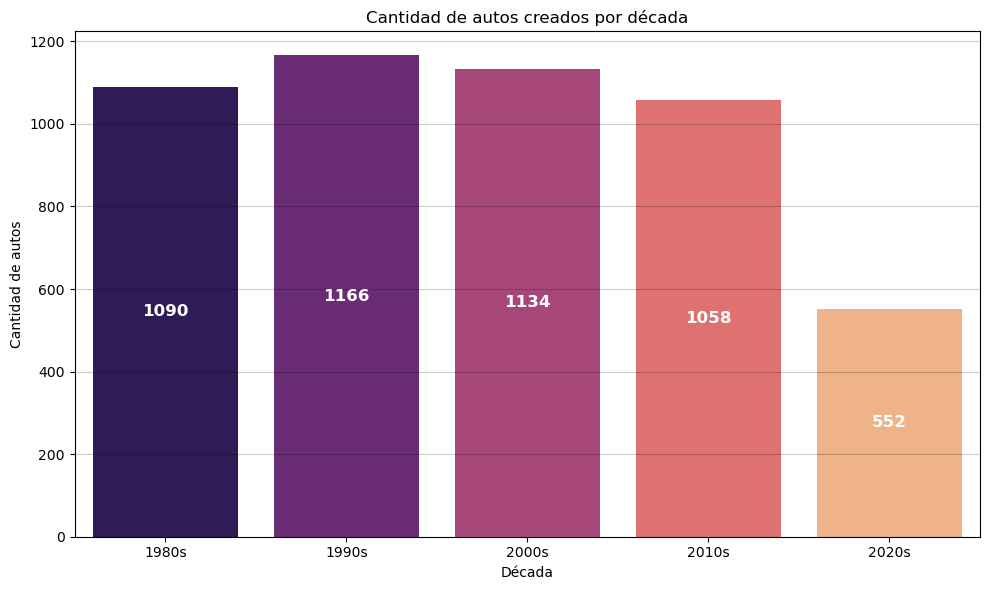

In [42]:
# Gráfico de barras con seaborn: cantidad de autos por década con valores en el centro
conteo_decadas = df['decada'].value_counts().sort_index()
plt.figure(figsize=(10,6))
bars = sns.barplot(x=conteo_decadas.index, y=conteo_decadas.values,hue=conteo_decadas.index, palette="magma", legend=False)
plt.xlabel('Década')
plt.ylabel('Cantidad de autos')
plt.title('Cantidad de autos creados por década')
plt.grid(axis='y', color='black', alpha=0.2)
plt.tight_layout()

for bar, valor in zip(bars.patches, conteo_decadas.values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() / 2,
        str(valor),
        ha='center',
        va='center',
        color='white',
        fontweight='bold',
        fontsize=12
    )

plt.show()

### Conclusión del gráfico de autos por década
Como conclusión del primer gráfico podemos ver claramente cómo los años 1990s y 2000s fueron la década donde más autos se fabricaron con respecto a las otras.

## GRAFICO II
Este grafico esta diseñado con la finalidad de saber que tipo de traccion es la mas utilizada en el mundo automovil.

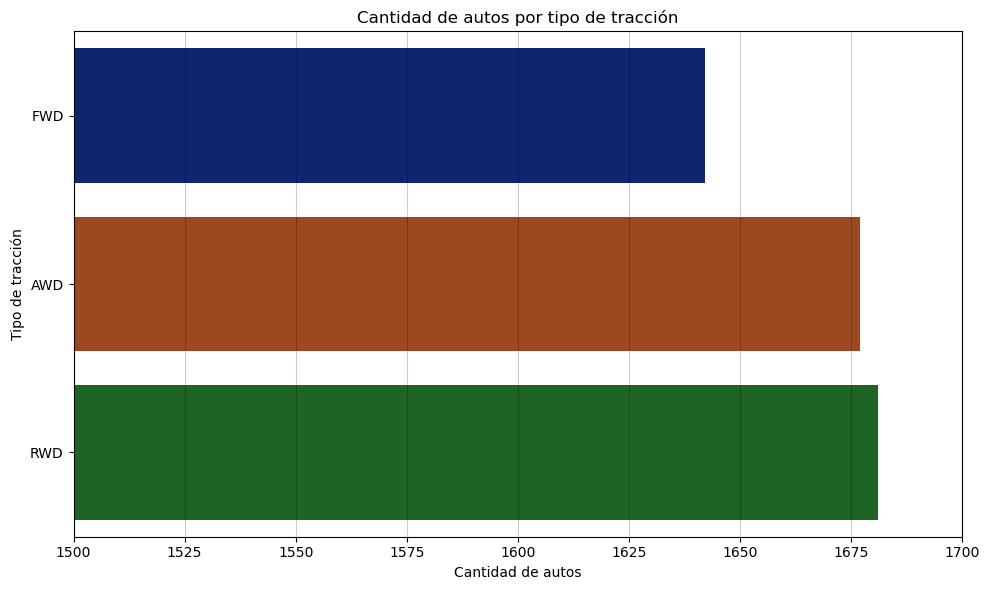

In [43]:
# Gráfico de barras horizontales con seaborn: cantidad de autos por tipo de tracción
conteo_traccion = df['Drivetrain'].value_counts().sort_values()
plt.figure(figsize=(10,6))
bars = sns.barplot(x=conteo_traccion.values, y=conteo_traccion.index,hue=conteo_traccion.values, palette="dark", legend=False)
plt.xlabel('Cantidad de autos')
plt.ylabel('Tipo de tracción')
plt.title('Cantidad de autos por tipo de tracción')
plt.xlim(1500, 1700)  # Limitar el eje X entre 1500 y 1700
plt.grid(axis='x', color='black', alpha=0.2)
plt.tight_layout()
plt.show()

### Conclusión del gráfico de tipo de tracción
Como conclusión del gráfico podemos ver cómo la tracción más utilizada es la RWD (Traccion trasera), seguida por la AWD (Traccion en las 4 ruedas) y por último la FWD (Traccion delantera).

Al tener muchos valores de potencia diferente para cada auto decidi hacer lo mismo que con las decadas y agrupar por grupos de potencias

In [44]:
def clasificar_potencia(df):

    condiciones = [
        df['Horsepower'] <= 593,
        (df['Horsepower'] > 593) & (df['Horsepower'] <= 1057),
        df['Horsepower'] > 1057
    ]
    opciones = ['Potencia baja', 'Potencia media', 'Potencia alta']
    df['Grupo_Potencia'] = np.select(condiciones, opciones, default='Desconocido')
    return df

# Aplicar la función al DataFrame
df = clasificar_potencia(df)
display(df[['Horsepower', 'Grupo_Potencia']].head())

,Horsepower,Grupo_Potencia
0,420,Potencia baja
1,1104,Potencia alta
2,153,Potencia baja
3,544,Potencia baja
4,980,Potencia media


## GRAFICO III
Este grafico esta diseñado con la finalidad de saber la eficiencia de combustible, si fue decendiendo o aumentando a travez del tiempo.

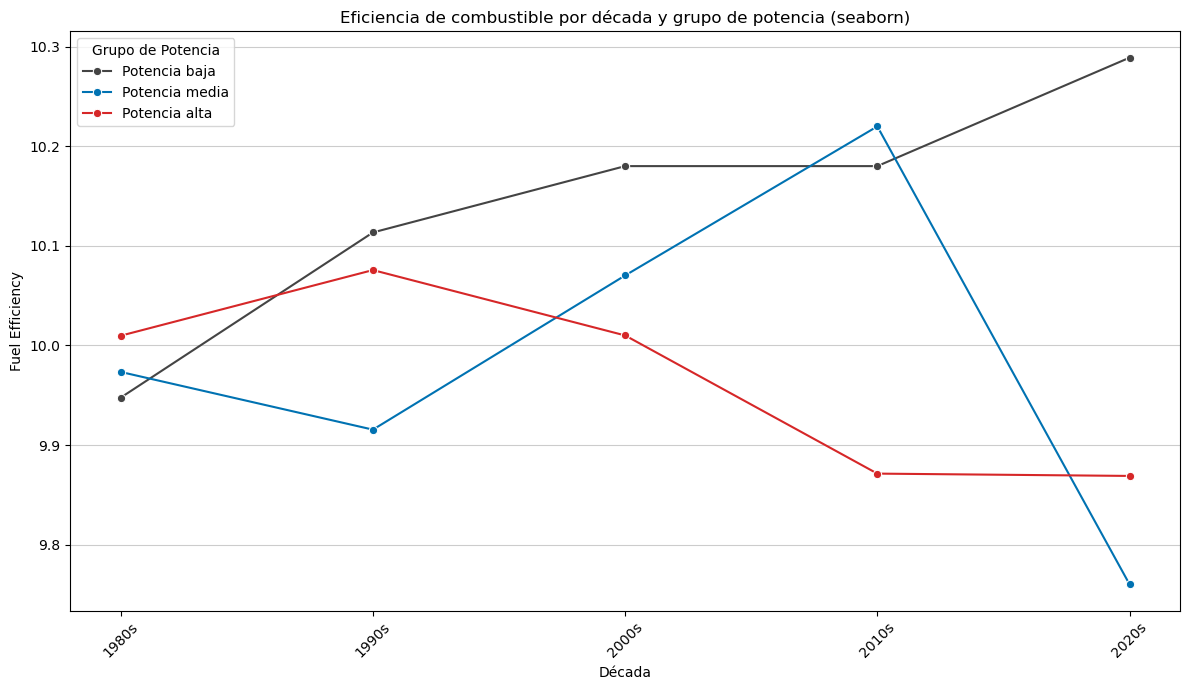

In [45]:
# Gráfico de líneas con seaborn: eficiencia de combustible por década y grupo de potencia
plt.figure(figsize=(12,7))
grupos = ['Potencia baja', 'Potencia media', 'Potencia alta']
colores_grupo = {
    'Potencia baja': '#444444',   # gris oscuro
    'Potencia media': '#0072B2', # azul
    'Potencia alta': '#D62728'   # rojo
}
for grupo in grupos:
    datos_grupo = df[df['Grupo_Potencia'] == grupo]
    promedio = datos_grupo.groupby('decada')['Fuel_Efficiency'].mean().sort_index()
    sns.lineplot(x=promedio.index, y=promedio.values, label=grupo, color=colores_grupo[grupo], marker='o')
plt.xlabel('Década')
plt.ylabel('Fuel Efficiency')
plt.title('Eficiencia de combustible por década y grupo de potencia (seaborn)')
plt.legend(title='Grupo de Potencia')
plt.xticks(rotation=45)
plt.grid(axis='y', color='black', alpha=0.2)
plt.tight_layout()
plt.show()

### Conclusión del gráfico de eficiencia de combustible
Como conclusión del gráfico se puede ver cómo la eficiencia de combustible fue positiva para motores con una Potencia baja, mientras que la eficiencia para Potencia media y Alta fue decayendo a medida que pasa el tiempo.

## GRAFICO IV
Este grafico esta diseñado con la finalidad de saber la contaminacion de CO2, si fue decendiendo o aumentando a travez del tiempo.

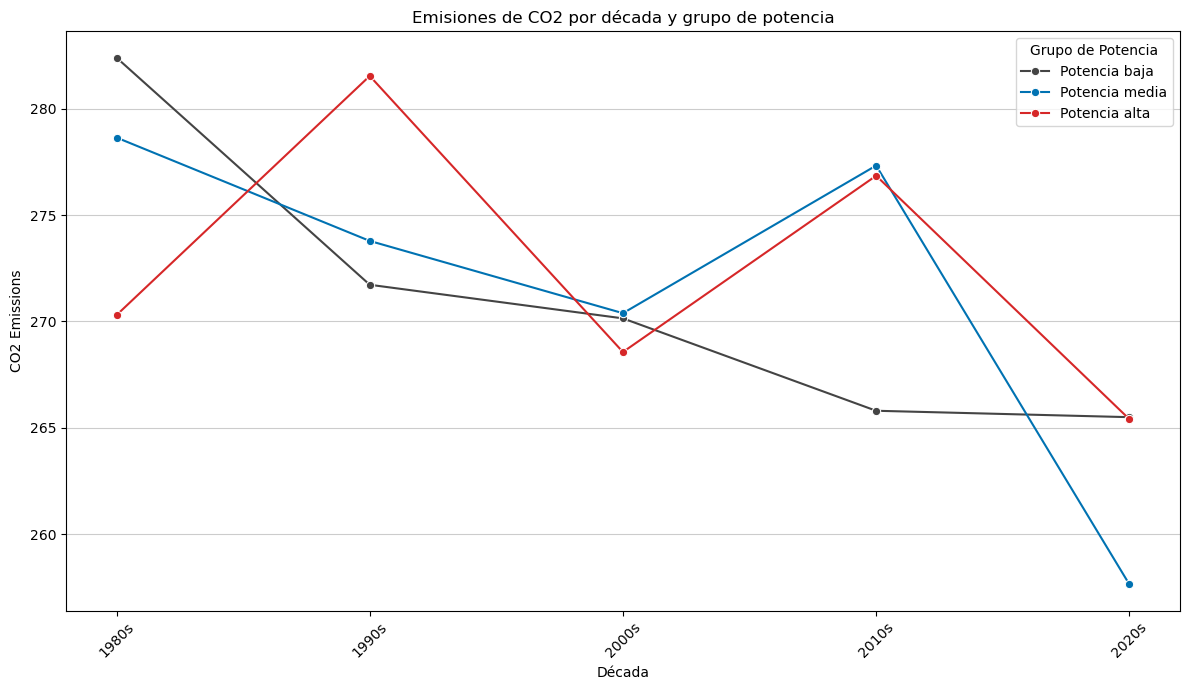

In [46]:
# Gráfico de líneas con seaborn: emisiones de CO2 por década y grupo de potencia
plt.figure(figsize=(12,7))
grupos = ['Potencia baja', 'Potencia media', 'Potencia alta']
colores_grupo = {
    'Potencia baja': '#444444',   # gris oscuro
    'Potencia media': '#0072B2', # azul
    'Potencia alta': '#D62728'   # rojo
}
for grupo in grupos:
    datos_grupo = df[df['Grupo_Potencia'] == grupo]
    promedio = datos_grupo.groupby('decada')['CO2_Emissions'].mean().sort_index()
    sns.lineplot(x=promedio.index, y=promedio.values, label=grupo, color=colores_grupo[grupo], marker='o')
plt.xlabel('Década')
plt.ylabel('CO2 Emissions')
plt.title('Emisiones de CO2 por década y grupo de potencia')
plt.legend(title='Grupo de Potencia')
plt.xticks(rotation=45)
plt.grid(axis='y', color='black', alpha=0.2)
plt.tight_layout()
plt.show()

### Conclusión del gráfico de emisiones de CO2
Como se puede ver en este gráfico, los autos con motores de potencia media son los menos contaminantes actualmente, Estos tuvieron una evolución positiva a lo largo del tiempo logrando contaminar menos al ambiente. Por el contrario, los motores con una Potencia baja y alta, aunque tuvieron una bajada, son más contaminantes que el anterior, aunque siguen siendo valores relativamente bajos.

Una ves terminada la exploracion y interiorizarnos mas en nuestro df, pasamos a la parte donde vamos a empezar con el algoritmo, en este caso voy a usar un algoritmo de regresion lineal, La regresión lineal múltiple es un modelo estadístico que permite estimar y explicar la relación entre una variable dependiente (Y) y dos o más variables independientes (X₁, X₂, …, Xₙ).

 Su objetivo es cuantificar cómo cambia Y cuando cada predictor varía, manteniendo los demás constantes.



Lo que procemos a hacer es preparar los datos para el modelo de regresion, realizamos OHE, en las varialbles 'Drivetrain', 'Fuel_Type' para poder pasar de valores cualitativos a cuantitativos asi elmodelo funciona correctamente

In [47]:
# Crear copias de las variables con sufijo _h
for col in ['Brand', 'Fuel_Type', 'Drivetrain', 'Condition']:
    df[col + '_h'] = df[col].copy()

# One Hot Encoding sobre las nuevas variables
variables_ohe = ['Brand_h', 'Fuel_Type_h', 'Drivetrain_h', 'Condition_h']
df = pd.get_dummies(df, columns=variables_ohe)

display(df.head())

,Brand,Model,Year,Country,Condition,Engine_Size,Horsepower,Torque,Weight,Top_Speed,...,Fuel_Type_h_Diesel,Fuel_Type_h_Electric,Fuel_Type_h_Petrol,Drivetrain_h_AWD,Drivetrain_h_FWD,Drivetrain_h_RWD,Condition_h_new,Condition_h_restored,Condition_h_salvage,Condition_h_used
0,Nissan,720S,2006-01-01,Asia,used,3.7,420,705,1785,238,...,True,False,False,False,False,True,False,False,False,True
1,McLaren,911 Turbo S,2009-01-01,Europe,new,5.3,1104,766,992,386,...,False,True,False,False,False,True,True,False,False,False
2,Chevrolet,M4 Competition,2009-01-01,USA,new,5.5,153,1573,2022,397,...,True,False,False,False,True,False,True,False,False,False
3,Bugatti,Chiron,1982-01-01,Asia,used,5.4,544,1009,1091,151,...,False,False,True,False,False,True,False,False,False,True
4,Nissan,Chiron,2022-01-01,Europe,new,2.4,980,693,1232,385,...,False,False,True,True,False,False,True,False,False,False


In [58]:
# Definir función para eliminar outliers (se usará después del OHE)
def eliminar_outliers_iqr(df, columnas):
    """
    Elimina outliers usando el método IQR (Rango Intercuartílico).
    Para cada columna, elimina valores fuera del rango [Q1 - 1.5*IQR, Q3 + 1.5*IQR]
    """
    df_sin_outliers = df.copy()
    filas_antes = len(df_sin_outliers)
    
    for col in columnas:
        if col in df_sin_outliers.columns and pd.api.types.is_numeric_dtype(df_sin_outliers[col]):
            Q1 = df_sin_outliers[col].quantile(0.25)
            Q3 = df_sin_outliers[col].quantile(0.75)
            IQR = Q3 - Q1
            limite_inferior = Q1 - 1.5 * IQR
            limite_superior = Q3 + 1.5 * IQR
            
            # Filtrar
            df_sin_outliers = df_sin_outliers[
                (df_sin_outliers[col] >= limite_inferior) & 
                (df_sin_outliers[col] <= limite_superior)
            ]
    
    filas_despues = len(df_sin_outliers)
    filas_eliminadas = filas_antes - filas_despues
    
    return df_sin_outliers, filas_eliminadas

print('Función eliminar_outliers_iqr definida')
print('Se aplicará después de realizar el OHE de las variables categóricas')

Función eliminar_outliers_iqr definida
Se aplicará después de realizar el OHE de las variables categóricas


---

## 🚀 Modelo XGBoost: Que variable es la mas influyente

Ahora implementaremos un modelo **XGBoost (Extreme Gradient Boosting)** para predecir el precio de los autos usando la variable transformada `Log_Price` como objetivo.

**¿Por qué XGBoost?**
- Algoritmo de boosting más potente y rápido
- Excelente rendimiento en problemas de regresión
- Manejo automático de valores faltantes
- Control avanzado de sobreajuste (regularización L1/L2)
- Mayor precisión que Random Forest en muchos casos

**Variables de entrada:**
- **Numéricas continuas**: Engine_Size, Horsepower, Torque, Weight, Top_Speed, Acceleration_0_100, Fuel_Efficiency, CO2_Emissions, Mileage, Safety_Rating, Number_of_Owners, Insurance_Cost
- **Dummies codificadas**: Brand_h_*, Fuel_Type_h_*, Drivetrain_h_*

**Variable objetivo:** Log_Price (transformación logarítmica del precio)


## PASO 1: PREPARACIÓN DE DATOS PARA XGBOOST 

In [52]:

variables_numericas_originales = [
    'Engine_Size',
    'Horsepower', 
    'Torque',
    'Weight',
    'Top_Speed',
    'Acceleration_0_100',
    'Fuel_Efficiency',
    'CO2_Emissions',
    'Mileage',
    'Safety_Rating',
    'Number_of_Owners'
]

condition_h_cols = [col for col in df.columns if 'Condition_h_' in col]
variables_predictoras_xgb = variables_numericas_originales.copy() + condition_h_cols

X_xgb = df[variables_predictoras_xgb].copy()
y_xgb = df['Price'].copy()

nulos_X = X_xgb.isnull().sum().sum()
nulos_y = y_xgb.isnull().sum()
infinitos_X = X_xgb.select_dtypes(include=[np.number]).apply(lambda x: np.isinf(x).sum()).sum()

if nulos_X > 0 or nulos_y > 0 or infinitos_X > 0:
    X_xgb = X_xgb.replace([np.inf, -np.inf], np.nan)
    indices_validos = X_xgb.notnull().all(axis=1) & y_xgb.notnull()
    X_xgb = X_xgb[indices_validos]
    y_xgb = y_xgb[indices_validos]


## PASO 2: División Train/Test y Entrenamiento

Dividimos los datos en conjuntos de entrenamiento (80%) y prueba (20%) y finalmente entrenamos el modelo XGBoost con parámetros optimizados.

In [53]:
# División train/test (80% - 20%)
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X_xgb, y_xgb, test_size=0.2, random_state=42
)

print('División completada:')
print(f'   Conjunto de entrenamiento: {X_train_xgb.shape[0]:,} muestras')
print(f'   Conjunto de prueba: {X_test_xgb.shape[0]:,} muestras')

# Parametros
modelo_xgb = xgb.XGBRegressor(
    n_estimators=600,          
    max_depth=4,              
    learning_rate=0.02,        
    subsample=0.65,            
    colsample_bytree=0.65,     
    min_child_weight=18,      
    reg_alpha=1.0,            
    reg_lambda=7,              
    gamma=0.3,                 
    random_state=42,           
    n_jobs=-1,              
    verbosity=0              
)

# Entrenar el modelo
print('\n🚀 Entrenando modelo XGBoost...')

modelo_xgb.fit(X_train_xgb, y_train_xgb)


print(' Modelo XGBoost enrenado!')
print('='*70)

División completada:
   Conjunto de entrenamiento: 4,000 muestras
   Conjunto de prueba: 1,000 muestras

🚀 Entrenando modelo XGBoost...
 Modelo XGBoost enrenado!


## PASO 3: Evaluación del Modelo XGBoost

Calculamos las métricas de rendimiento del modelo: R², MAE (Error Absoluto Medio) y RMSE (Raíz del Error Cuadrático Medio) para evaluar la precisión del modelo tanto en datos de entrenamiento como de prueba.

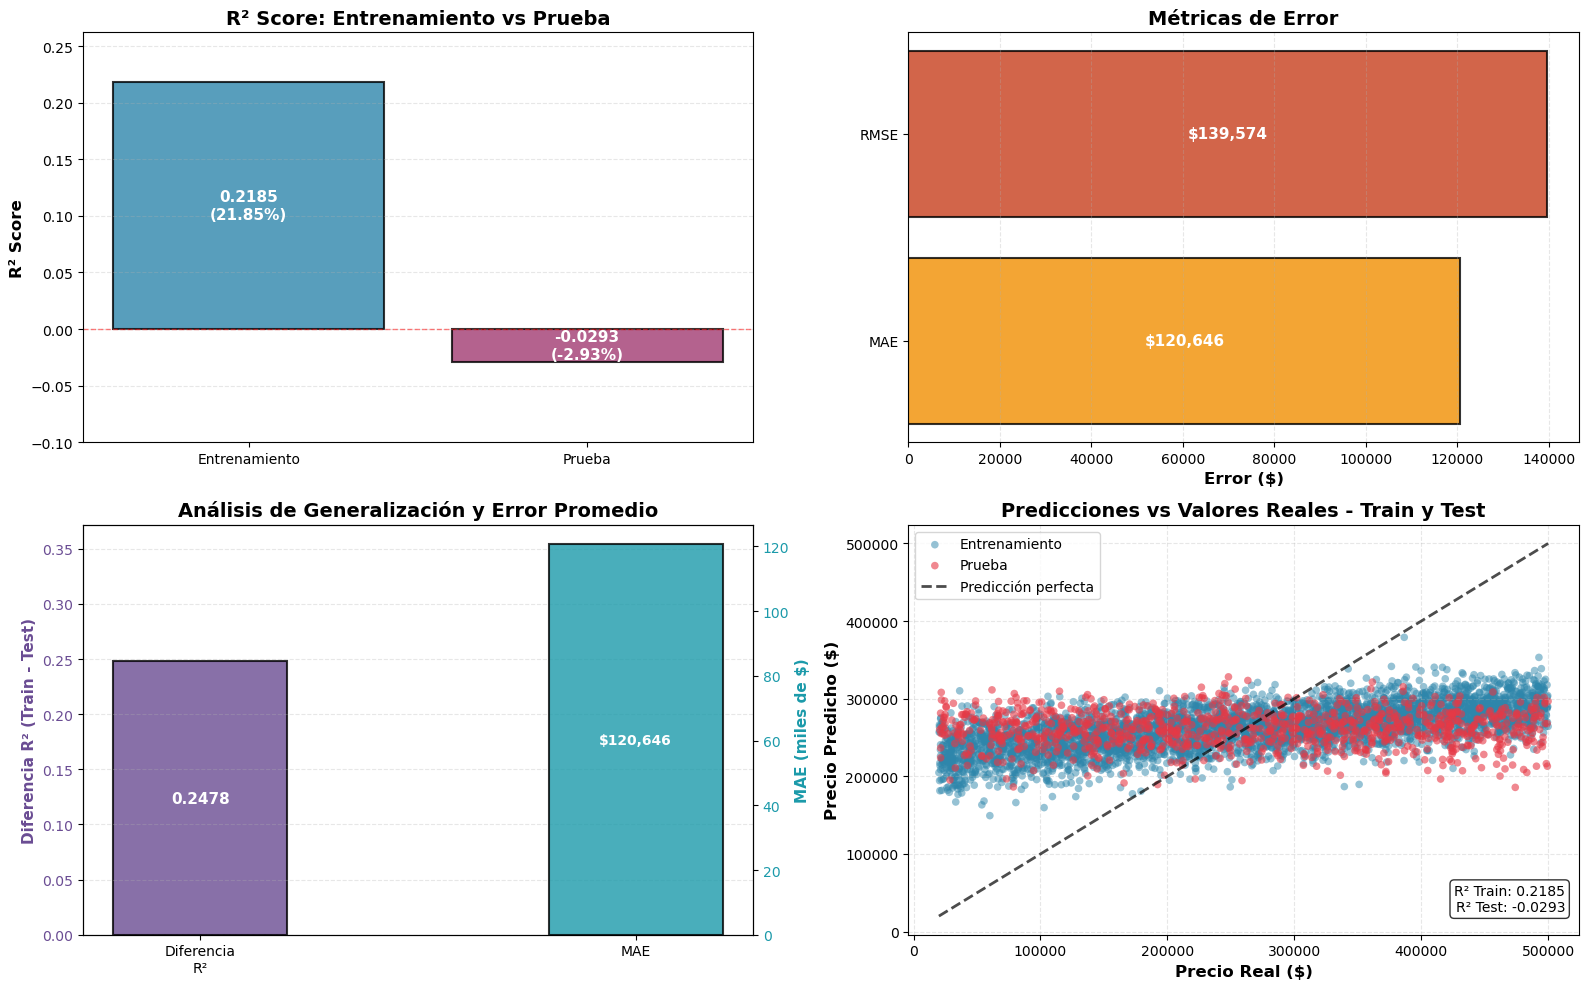

In [54]:
y_train_pred_xgb = modelo_xgb.predict(X_train_xgb)
y_test_pred_xgb = modelo_xgb.predict(X_test_xgb)

r2_train_xgb = r2_score(y_train_xgb, y_train_pred_xgb)
r2_test_xgb = r2_score(y_test_xgb, y_test_pred_xgb)
mae_test_xgb = mean_absolute_error(y_test_xgb, y_test_pred_xgb)
rmse_test_xgb = np.sqrt(mean_squared_error(y_test_xgb, y_test_pred_xgb))

diferencia_r2_xgb = r2_train_xgb - r2_test_xgb

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

r2_data = pd.DataFrame({
    'Conjunto': ['Entrenamiento', 'Prueba'],
    'R² Score': [r2_train_xgb, r2_test_xgb]
})

bars = axes[0, 0].bar(r2_data['Conjunto'], r2_data['R² Score'], 
                       color=['#2E86AB', '#A23B72'], edgecolor='black', linewidth=1.5, alpha=0.8)
axes[0, 0].set_ylabel('R² Score', fontsize=12, fontweight='bold')
axes[0, 0].set_title('R² Score: Entrenamiento vs Prueba', fontsize=14, fontweight='bold')
axes[0, 0].set_ylim(-0.1, max(r2_train_xgb, r2_test_xgb) * 1.2)
axes[0, 0].grid(axis='y', alpha=0.3, linestyle='--')
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)

for bar, valor in zip(bars, r2_data['R² Score']):
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height/2,
                    f'{valor:.4f}\n({valor*100:.2f}%)',
                    ha='center', va='center', fontsize=11, fontweight='bold', color='white')

metricas_error = pd.DataFrame({
    'Métrica': ['MAE', 'RMSE'],
    'Valor': [mae_test_xgb, rmse_test_xgb]
})

bars2 = axes[0, 1].barh(metricas_error['Métrica'], metricas_error['Valor'],
                         color=['#F18F01', '#C73E1D'], edgecolor='black', linewidth=1.5, alpha=0.8)
axes[0, 1].set_xlabel('Error ($)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Métricas de Error', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3, linestyle='--')

for bar, valor in zip(bars2, metricas_error['Valor']):
    width = bar.get_width()
    axes[0, 1].text(width/2, bar.get_y() + bar.get_height()/2,
                    f'${valor:,.0f}',
                    ha='center', va='center', fontsize=11, fontweight='bold', color='white')

ax3 = axes[1, 0]
ax3_twin = ax3.twinx()

bar_dif = ax3.bar(['Diferencia\nR²'], [diferencia_r2_xgb], 
                   color='#6A4C93', edgecolor='black', linewidth=1.5, alpha=0.8, width=0.4)
ax3.set_ylabel('Diferencia R² (Train - Test)', fontsize=11, fontweight='bold', color='#6A4C93')
ax3.tick_params(axis='y', labelcolor='#6A4C93')
ax3.set_ylim(0, diferencia_r2_xgb * 1.5)

bar_mae = ax3_twin.bar(['MAE'], [mae_test_xgb/1000], 
                        color='#1B9AAA', edgecolor='black', linewidth=1.5, alpha=0.8, width=0.4)
ax3_twin.set_ylabel('MAE (miles de $)', fontsize=11, fontweight='bold', color='#1B9AAA')
ax3_twin.tick_params(axis='y', labelcolor='#1B9AAA')

ax3.set_title('Análisis de Generalización y Error Promedio', fontsize=14, fontweight='bold')
ax3.grid(axis='y', alpha=0.3, linestyle='--')

ax3.text(0, diferencia_r2_xgb/2, f'{diferencia_r2_xgb:.4f}',
         ha='center', va='center', fontsize=11, fontweight='bold', color='white')
ax3_twin.text(1, (mae_test_xgb/1000)/2, f'${mae_test_xgb:,.0f}',
              ha='center', va='center', fontsize=10, fontweight='bold', color='white')

y_train_pred_original = y_train_pred_xgb
y_train_original = y_train_xgb
y_test_pred_original = y_test_pred_xgb
y_test_original = y_test_xgb

axes[1, 1].scatter(y_train_original, y_train_pred_original, 
                   alpha=0.5, s=30, color='#2E86AB', edgecolors='none', label='Entrenamiento')

axes[1, 1].scatter(y_test_original, y_test_pred_original, 
                   alpha=0.6, s=30, color='#E63946', edgecolors='none', label='Prueba')

min_val = min(y_train_original.min(), y_test_original.min())
max_val = max(y_train_original.max(), y_test_original.max())
axes[1, 1].plot([min_val, max_val], [min_val, max_val], 
                'k--', linewidth=2, alpha=0.7, label='Predicción perfecta')

axes[1, 1].set_xlabel('Precio Real ($)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Precio Predicho ($)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Predicciones vs Valores Reales - Train y Test', fontsize=14, fontweight='bold')
axes[1, 1].legend(loc='upper left', fontsize=10)
axes[1, 1].grid(alpha=0.3, linestyle='--')

axes[1, 1].text(0.98, 0.05, 
                f'R² Train: {r2_train_xgb:.4f}\nR² Test: {r2_test_xgb:.4f}',
                transform=axes[1, 1].transAxes,
                fontsize=10, verticalalignment='bottom', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='black'))

plt.tight_layout()
plt.show()

### 📌 PASO 4: Importancia de Variables en XGBoost

Analizamos qué variables tienen mayor peso en el modelo XGBoost para predecir el precio. A diferencia de Random Forest, XGBoost calcula la importancia basándose en la ganancia de información al hacer splits.

In [55]:
# Obtener importancias del modelo XGBoost
importancias_xgb = modelo_xgb.feature_importances_
nombres_variables_xgb = X_train_xgb.columns

# Crear DataFrame con importancias
df_importancias_xgb = pd.DataFrame({
    'Variable': nombres_variables_xgb,
    'Importancia': importancias_xgb
}).sort_values('Importancia', ascending=False)

# Calcular porcentaje
df_importancias_xgb['Porcentaje'] = (df_importancias_xgb['Importancia'] / df_importancias_xgb['Importancia'].sum()) * 100

# Filtrar solo las TOP 20 variables para mostrar
top_20_xgb = df_importancias_xgb.head(20)

print('TOP 20 VARIABLES MÁS IMPORTANTES EN XGBOOST:')
print(f'{"#":<4} {"Variable":<35} {"Importancia":<12} {"Porcentaje":<10} {"Peso"}')
print('-'*80)

for i, (idx, row) in enumerate(top_20_xgb.iterrows(), 1):
    variable = row['Variable']
    importancia = row['Importancia']
    porcentaje = row['Porcentaje']
    
    # Barra visual
    barra_longitud = int(porcentaje / 2)
    barra = '█' * barra_longitud
    
    # Emoji según importancia
    if i <= 3:
        emoji = '🥇' if i == 1 else '🥈' if i == 2 else '🥉'
    elif porcentaje >= 3:
        emoji = '⭐'
    else:
        emoji = '  '
    
    print(f'{emoji} {i:<2} {variable:<35} {importancia:.4f}     {porcentaje:>5.2f}%   {barra}')

# Análisis de las top 5
print('\n' + '='*80)
print('                     ANÁLISIS DE LAS TOP 5 VARIABLES')
print('='*80)

top_5_xgb = df_importancias_xgb.head(5)
for i, (idx, row) in enumerate(top_5_xgb.iterrows(), 1):
    print(f'\n🏆 #{i} - {row["Variable"]}')
    print(f'   Importancia: {row["Importancia"]:.4f} ({row["Porcentaje"]:.2f}%)')
    
    # Información adicional según el tipo de variable
    if '_h_' in row["Variable"]:
        if 'Brand_h_' in row["Variable"]:
            marca = row["Variable"].replace('Brand_h_', '')
            print(f'   📌 Marca: {marca} - Influye significativamente en el precio')
        elif 'Fuel_Type_h_' in row["Variable"]:
            tipo = row["Variable"].replace('Fuel_Type_h_', '')
            print(f'   📌 Tipo de combustible: {tipo}')
        elif 'Drivetrain_h_' in row["Variable"]:
            traccion = row["Variable"].replace('Drivetrain_h_', '')
            print(f'   📌 Tipo de tracción: {traccion}')
    else:
        print(f'   📌 Variable numérica continua - Relación directa con el precio')

# Resumen general
print('\n' + '='*80)
print('                          RESUMEN')
print('='*80 + '\n')

top_10_suma = df_importancias_xgb.head(10)['Porcentaje'].sum()
top_20_suma = df_importancias_xgb.head(20)['Porcentaje'].sum()

print(f' Las TOP 10 variables explican el {top_10_suma:.1f}% de la importancia total')
print(f' Las TOP 20 variables explican el {top_20_suma:.1f}% de la importancia total')
print(f' La variable más importante es: {df_importancias_xgb.iloc[0]["Variable"]} ({df_importancias_xgb.iloc[0]["Porcentaje"]:.2f}%)')
print(f' Total de variables analizadas: {len(df_importancias_xgb)}')

# Separar importancia por tipo de variable
numericas_continuas_importancia = df_importancias_xgb[~df_importancias_xgb['Variable'].str.contains('_h_')]
dummies_importancia = df_importancias_xgb[df_importancias_xgb['Variable'].str.contains('_h_')]

print(f'\n📊 Importancia por tipo:')
print(f'   Variables numéricas continuas: {numericas_continuas_importancia["Porcentaje"].sum():.1f}%')
print(f'   Variables dummies (categóricas): {dummies_importancia["Porcentaje"].sum():.1f}%')

print('='*80)

TOP 20 VARIABLES MÁS IMPORTANTES EN XGBOOST:
#    Variable                            Importancia  Porcentaje Peso
--------------------------------------------------------------------------------
🥇 1  Condition_h_salvage                 0.0759      7.59%   ███
🥈 2  Top_Speed                           0.0713      7.13%   ███
🥉 3  Horsepower                          0.0707      7.07%   ███
⭐ 4  Number_of_Owners                    0.0700      7.00%   ███
⭐ 5  Mileage                             0.0697      6.97%   ███
⭐ 6  Torque                              0.0681      6.81%   ███
⭐ 7  Weight                              0.0678      6.78%   ███
⭐ 8  Condition_h_used                    0.0666      6.66%   ███
⭐ 9  CO2_Emissions                       0.0665      6.65%   ███
⭐ 10 Acceleration_0_100                  0.0664      6.64%   ███
⭐ 11 Fuel_Efficiency                     0.0663      6.63%   ███
⭐ 12 Engine_Size                         0.0656      6.56%   ███
⭐ 13 Safety_Rating      

### 📌 PASO 5: Visualización de la Importancia de Variables

Generamos gráficos para visualizar de forma clara qué variables tienen mayor peso en el modelo XGBoost.

C:\Users\joako\AppData\Local\Temp\ipykernel_8352\2530617994.py:39: UserWarning: Glyph 129351 (\N{FIRST PLACE MEDAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\joako\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129351 (\N{FIRST PLACE MEDAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


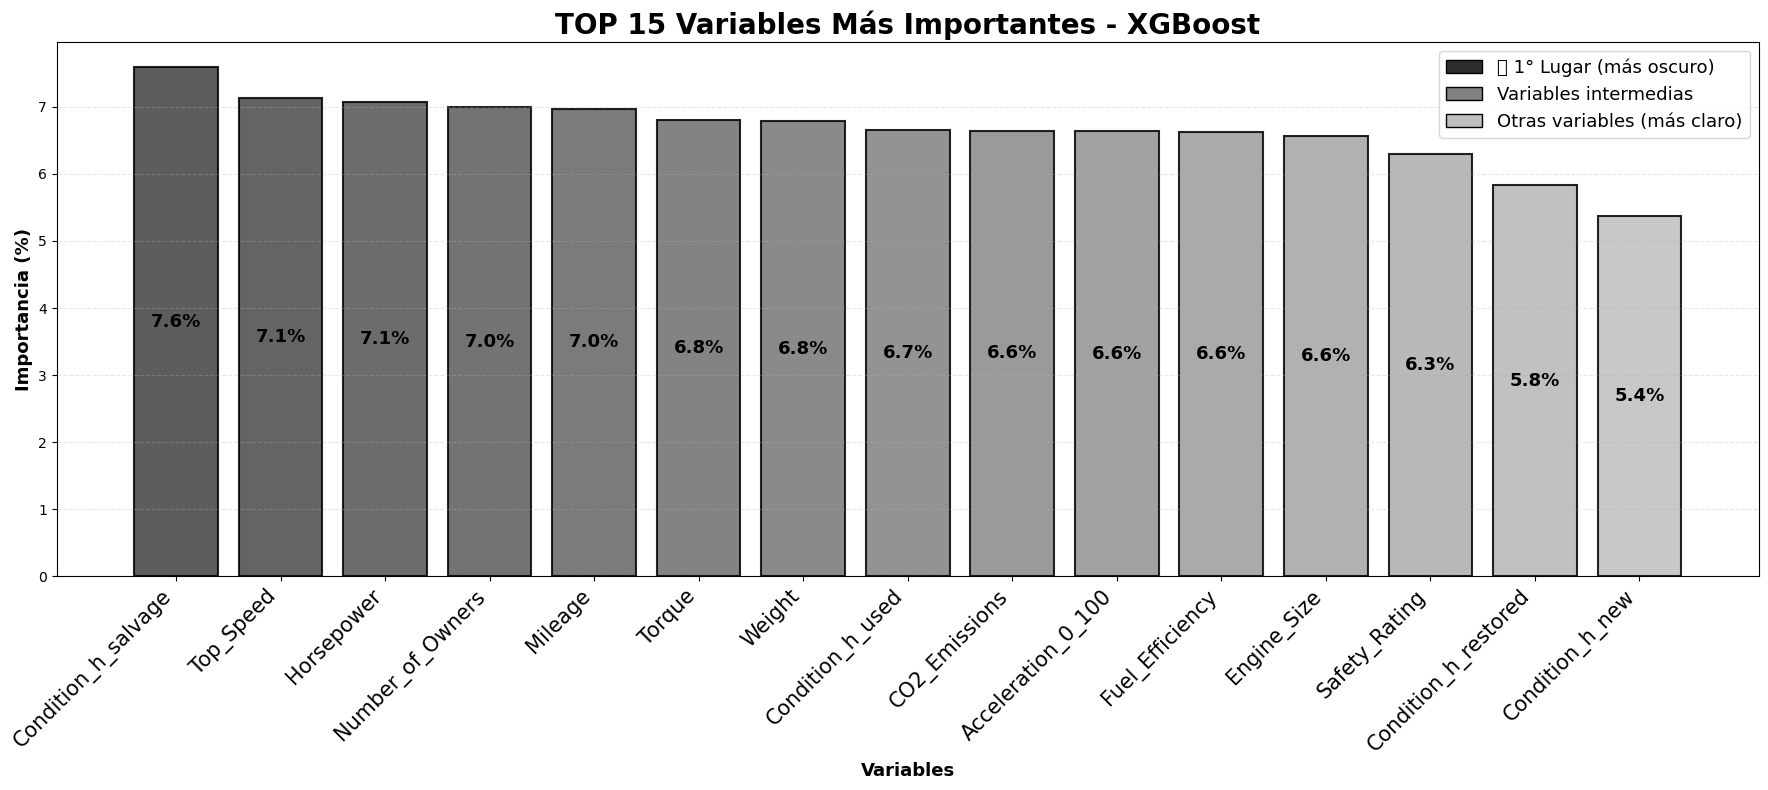

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(18, 8))

# Gráfico: TOP 15 variables con barras verticales
top_15 = df_importancias_xgb.head(15)

# Paleta de grises degradados para TOP 15
colores_top15 = [mcolors.to_hex((i/14 * 0.5 + 0.25, i/14 * 0.5 + 0.25, i/14 * 0.5 + 0.25)) 
                 for i in range(15)]

bars = ax.bar(range(len(top_15)), top_15['Porcentaje'], 
       color=colores_top15, edgecolor='black', alpha=0.85, linewidth=1.5)

ax.set_xlabel('Variables', fontsize=13, fontweight='bold')
ax.set_ylabel('Importancia (%)', fontsize=13, fontweight='bold')
ax.set_title('TOP 15 Variables Más Importantes - XGBoost', fontsize=20, fontweight='bold')
ax.set_xticks(range(len(top_15)))
ax.set_xticklabels(top_15['Variable'], rotation=45, ha='right', fontsize=15)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Agregar valores DENTRO de las barras (centrados verticalmente)
for i, (bar, valor) in enumerate(zip(bars, top_15['Porcentaje'])):
    # Calcular la posición vertical en el centro de la barra
    altura_barra = bar.get_height()
    posicion_y = altura_barra / 2
    
    ax.text(bar.get_x() + bar.get_width() / 2, posicion_y, 
            f"{valor:.1f}%", 
            ha='center', va='center', fontsize=13, fontweight='bold', color='black')

# Leyenda
legend_elements = [
    Patch(facecolor="#2E2D2D", label='🥇 1° Lugar (más oscuro)', edgecolor='black'),
    Patch(facecolor='#808080', label='Variables intermedias', edgecolor='black'),
    Patch(facecolor='#BFBFBF', label='Otras variables (más claro)', edgecolor='black')
]

ax.legend(handles=legend_elements, loc='upper right', fontsize=13)

plt.tight_layout()
plt.show()


